In [1]:
import time
import torch
import numpy as np
from numba import jit
import networkx as nx
from matplotlib import pyplot as plt
from label_spreading import *

plt.style.use('dark_background')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from joblib import Parallel, delayed

@jit(nopython=True)
def generate_adj_matrix(n, p):
    adjacency_matrix = np.random.rand(n, n) < p
    np.fill_diagonal(adjacency_matrix, 0)
    return adjacency_matrix.astype(np.float64)


def initialize_population(population_len, n, p, n_jobs=-1):
    population = Parallel(n_jobs=n_jobs)(
        delayed(generate_adj_matrix)(n, p) for _ in range(population_len)
    )
    return population

In [4]:
@jit(nopython=True)
def get_test_indices(data, test_size=0.3):
    test_indices_list = []
    
    for row in data:
        nonzero_indices = np.nonzero(row)[0]
        num_indices_to_keep = int(np.ceil(test_size * len(nonzero_indices)))
        selected_indices = np.random.choice(nonzero_indices, size=num_indices_to_keep, replace=False)
        test_indices_list.append(selected_indices)
    
    return test_indices_list


def run_label_spreading(W, original_data, predicted_data, test_indices, device, alpha=0.5, verbose=True):
    adj_matrix_t = torch.tensor(W, dtype=torch.float64)

    for i in range(original_data.shape[0]):
        train_data = original_data[i, :].copy()
        
        labels_t = torch.tensor( train_data , dtype=torch.long )

        if len(test_indices[i]):
            labels_t[labels_t == 0] = -1
            labels_t[test_indices[i]] = -1
        else:
            predicted_data[i, :] = labels_t
            continue    
            raise Exception('empty test')
            
        label_spreading = LabelSpreading(adj_matrix_t)
        label_spreading.fit(labels_t, alpha=alpha, verbose=verbose)
        label_spreading_output_labels = label_spreading.predict_classes()
        predicted_data[i, :] = label_spreading_output_labels


@jit(nopython=True)
def mean_absolute_error(y_true, y_pred, denom):
    return np.sum(np.abs(y_true - y_pred)) / denom


@jit(nopython=True)
def mean_squared_error(y_true, y_pred, denom):
    return np.sum((y_true - y_pred) ** 2) / denom


def get_fitness(original_data, predicted_data, test_indices):
    e = []

    for i in range(original_data.shape[0]):
        if len(test_indices[i]):
            
            y_true = original_data[i, test_indices[i]].astype(np.int8)
            y_pred = predicted_data[i, test_indices[i]].astype(np.int8)

            mse = mean_squared_error(y_true, y_pred, len(y_true))
            e.append(mse)
        # else:
            # raise Exception('empty test sample')
                
    return -np.sum(e) / len(test_indices)


def evaluate_population(population, original_data, test_indices, device, verbose=True):
    scores = [ [i, None, None] for i in range(len(population)) ] 
    
    for i in range(len(population)):
        predicted_data = np.empty_like(original_data)
        run_label_spreading(population[i], original_data, predicted_data, test_indices, device=device, verbose=verbose)
        scores[i][1] = get_fitness(original_data, predicted_data, test_indices)
        scores[i][2] = predicted_data
        
    return scores

In [5]:
def mutate(adj_matrix, mutation_rate=0.01):
    mutation_mask = np.random.rand(*adj_matrix.shape) < mutation_rate
    mutated_matrix = np.logical_xor(adj_matrix, mutation_mask).astype(np.float64)

    np.fill_diagonal(mutated_matrix, 0)
    return mutated_matrix


def crossover(W1, W2, W1_fitness, W2_fitness):
    W1_weight = W1_fitness / (W1_fitness + W2_fitness)
    W2_weight = W2_fitness / (W1_fitness + W2_fitness)

    new_W = (W1 * W1_weight + W2 * W2_weight).astype(np.float64)
    np.fill_diagonal(new_W, 0)

    return new_W

In [6]:
def elitist_selection(sorted_scores, elite_percentage):
    elite_size = int(len(sorted_scores) * elite_percentage)
    elites_indices = [ sorted_scores[i][0]  for i in range(elite_size) ]
    return elites_indices


def tournament_selection(scores, elite_indices, num_parents):
    parents_indices = elite_indices.copy()
    parents_indices_set = set(parents_indices)
    individuals_indices = set(range(len(scores)))

    while len(parents_indices) < num_parents:
        available_indices = list(individuals_indices - parents_indices_set)
        try:
            tournament_indices = np.random.choice(available_indices, len(available_indices), replace=False)
        except Exception:
            raise f'unable to create tournament of size: {len(available_indices)} from {len(available_indices)} individuals (without replacement)'

        tournament_scores = [ (i, scores[i][1]) for i in tournament_indices ]
        winner_idx = max(tournament_scores, key=lambda x: x[1])[0]

        if winner_idx not in parents_indices:
            parents_indices.append(winner_idx)
            parents_indices_set.add(winner_idx)
    
    return parents_indices 

In [7]:
def run_simulated_annealing(og_individual, og_fitness, data, test_indices, tolerance, max_iterations, mutation_rate, device):
    best_fitness = og_fitness
    new_individual = og_individual.copy()

    for _ in range(max_iterations):
        new_individual = mutate(new_individual, mutation_rate)
        new_individual_fitness = evaluate_population([new_individual], data, test_indices, device=device, verbose=False)[0][1]
        
        offspring = crossover(og_individual, new_individual, og_fitness, new_individual_fitness)
        offspring_fitness = evaluate_population([offspring], data, test_indices, device=device, verbose=False)[0][1]
        
        if offspring_fitness >= tolerance * best_fitness:
            return offspring
                        
    return None

In [8]:
D = np.load('D_matrix.npy', mmap_mode='r')
D.shape

(44827, 10523)

In [9]:
import os
import psutil

memory_gb = psutil.virtual_memory().total / 1024**3
print(f'{memory_gb=}')

num_users = 600
# num_users = D.shape[0]
print(f'{num_users=}')

num_items = 10
# num_items = D.shape[1]
print(f'{num_items=}')

num_cpus = os.cpu_count()
print(f'{num_cpus=}')

partitions = num_cpus - 1
population_len = 35
print(f'{partitions=}, {population_len=}')
p = 0.1

memory_gb=62.581451416015625
num_users=600
num_items=10
num_cpus=32
partitions=31, population_len=35


In [10]:
original_data = D.T[:num_items, :num_users].copy()
original_data.shape, np.count_nonzero(original_data) / original_data.size * 100

((10, 600), 16.766666666666666)

In [11]:
epochs = 350
hist = np.zeros(shape=(epochs, 2), dtype=np.float64)

test_indices = get_test_indices(original_data, test_size=0.2)

max_iterations_values = [5 + (i // 20) for i in range(1, epochs + 1)]

tolerance_values = np.concatenate( [np.linspace(1.2, 0.99, epochs // 2), np.linspace(1.1, 1.1, epochs // 2)] )
if epochs % 2 == 1:
    tolerance_values = np.concatenate([tolerance_values, [1.09]])

mutation_rate_values = np.linspace(0.1, 0.005, epochs)
population = initialize_population(population_len=population_len, n=num_users, p=p)

In [12]:
og_population = population.copy()
og_population[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

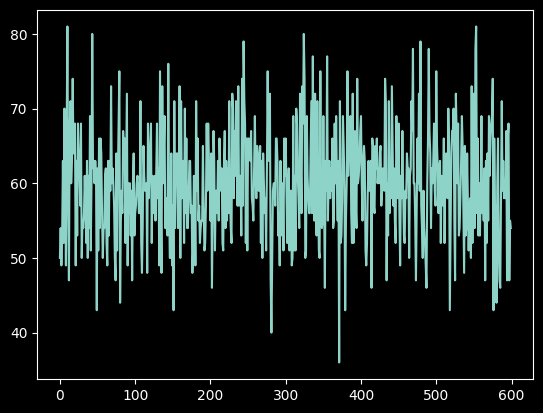

In [14]:
plt.plot(og_population[0].sum(0))

In [15]:
import time
import random
elites_indices = []

for i in range(epochs):
    start = time.time()

    mutation_rate = mutation_rate_values[i]
    tolerance = tolerance_values[i]
    max_iterations = max_iterations_values[i]

    scores = evaluate_population(population, original_data, test_indices, device=device, verbose=False)

    valid_scores = [x for x in scores if x[1] != np.finfo(float).max]    
    average_fitness = sum(x[1] for x in valid_scores) / len(valid_scores)
    valid_scores = sorted(valid_scores, key=lambda x:x[1], reverse=True)

    best_fitness = valid_scores[0][1]
    print(f'{i}: {average_fitness=}, {best_fitness=}', end=' ')

    hist[i][0] = average_fitness
    hist[i][1] = best_fitness
    
    elites_indices = elitist_selection(valid_scores, 0.4)
    parents_indices = tournament_selection(valid_scores, elites_indices, population_len // 2)
    random.shuffle(parents_indices)

    parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   

    new_population = [
            crossover(
                population[pair[0]], 
                population[pair[1]],
                scores[pair[0]][1], 
                scores[pair[1]][1], 
            ) for pair in parent_pairs 
        ]

    diff = population_len - len(new_population) - len(parents_indices)
    
    if diff > 0:        
        random.shuffle(parents_indices)
        parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   
        cnt = 0

        for j in range(diff):
            idx, fitness = valid_scores[j][0], valid_scores[j][1]
            new_individual = run_simulated_annealing(population[idx], fitness, original_data, test_indices, tolerance, max_iterations, mutation_rate, device=device) 
            
            if new_individual is not None:
                new_population.append(new_individual)
                cnt += 1
            else:
                new_population.append(generate_adj_matrix(num_users, p))
        print(f'changed: {cnt}/{diff}', end=' ')

    new_population.extend([ population[j] for j in parents_indices ])
    population = new_population.copy()

    end = time.time()
    print(f'elapsed time: {end - start}')

0: average_fitness=-6.328766583706655, best_fitness=-5.2154738675958185 changed: 10/10 elapsed time: 1.2019429206848145
1: average_fitness=-5.853319080803055, best_fitness=-5.003582462253194 changed: 10/10 elapsed time: 0.6470682621002197
2: average_fitness=-5.591181300813009, best_fitness=-4.7276922183507555 changed: 9/10 elapsed time: 1.7030715942382812
3: average_fitness=-5.424596781151484, best_fitness=-4.7276922183507555 changed: 10/10 elapsed time: 0.5691442489624023
4: average_fitness=-5.169702737680439, best_fitness=-4.717915795586528 changed: 9/10 elapsed time: 0.7235827445983887
5: average_fitness=-5.086879210220674, best_fitness=-4.717915795586528 changed: 10/10 elapsed time: 0.543520450592041
6: average_fitness=-4.984180786460927, best_fitness=-4.678725319396051 changed: 10/10 elapsed time: 0.6005747318267822
7: average_fitness=-4.944892400862786, best_fitness=-4.49624912891986 changed: 10/10 elapsed time: 0.6167140007019043
8: average_fitness=-4.844837249045961, best_fitne

KeyboardInterrupt: 